МФТИ ФИВТ, Машинное обучение, Никита Волков

# Ранжирование

Дедлайн **24 ноября 23:59** для 399 группы и **25 ноября 23:59** для остальных групп.


Для выполнения задания потребуются следующие библиотеки: bs4, urllib, networkx. Следующими командами можно их поставить (Ubuntu):

sudo pip3 install beautifulsoup4

sudo pip3 install urllib2

sudo pip3 install networkx

Используемый питон: 3

--------------

Прежде чем начать читать задание, просто посмотрите на картинку ранжирования котов :)

<img width=500 src="./resize.jpg">

# Тест

**1.** Что является объектом в задаче обучения ранжированию? Какой смысл имеют целевые метки? Какие объекты сравнимы между собой?

Объект - то, что необходимо упорядочить (то есть для поисковой системы объектами являются документы, соответствующие данному запросу). Между собой сравнимы объекты, которые относятся к одному событию (то есть документы, которые релеванты запросу).

**2.** В чем преимущество метрики NDCG перед метрикой MAP?

NDCG не накладывает ограничений на возможные значения релевантности.

**3.** Почему говорят, что все основные метрики качества дискретны?

Потому что они действительно дискретны.. У нас есть конечное количество способов упорядочить объекты.

**4.** В чем преимущество факторизации в модели RankNet?

Ускоряет обучение (от квадратного времени перешли к линейному).

**5.** Как решается проблема дискретности метрик в моделях LambdaRank и LambdaMART?

Оптимизируется гладкая функция с таким же градиентом, как и у дискретной метрики.

**6.** Какое преобразование данных используется в модели RankSVM?

N-классовое ранжирование преобразовывается в бинарную классификацию, также называемую попарным ранжированием.

**7.** Как изменится верхняя оценка на скорость сходимости в модели PageRank, если считать, что при операции телепортации пользователь всегда выбирает страницу, отличную от текущей?

Вместо V станет V-1. То есть $p_{ij}$ увеличится. Тогда увеличится и $\varepsilon$. То есть скорость сходимости возрастет.

**8.** Имеет ли смысл выполнять итерации в методе power iteration для разных начальных распределений $\Pi^{(0)}$ с точки зрения теории? А с точки зрения практического применения, не обязательно при этом доводя до сходимости?

С точки зрения теории - не имеет, все равно сходится к определенному распределению. С точки зрения практического применения имеет, так как если мы знаем несколько распределений, то можем попробовать поработать с каждым и взять то, которое лучше сходится.

# Задачи

(студенты 399 группы могут принести решение на листочках на семинар)

**1.** Предположим, что известные вероятностности в модели RankNet задаются по правилу
$$Q_{ij} = \mathsf{Q}(X_i \triangleright X_j) = \frac{1}{1 + e^{-\sigma (Y_i - Y_j)}}.$$
Можно ли провести факторизацию в данной модели?

**2.** Покажите, что вес PageRank каждой страницы не меньше $\frac{p}{|V|}$.

1) $1 > p$ =>  $\frac{1}{|V|} > \frac{p}{|V|}$

2) $\frac{p}{|V|} + x > \frac{p}{|V|}$, так как x > 0

**3.** Пользователь браузера в дополнение к кликам по ссылкам один раз может перейти по кнопке *Назад* и вернуться на предыдущую страницу. Можно ли такую модель описать с помощью однородной марковской цепи? Если да, опишите, если нет, докажите.


## Часть 1

In [1]:
import numpy as np
from scipy.stats import bernoulli
import networkx
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse, urlunparse
from time import sleep
from itertools import product
import matplotlib.pyplot as plt

%matplotlib inline
# plt.rc('text', usetex=False)
# plt.rc('text', usetex=True)
# plt.rc('text.latex', unicode=True)
# plt.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
# plt.rc('text.latex', preamble='\\usepackage[russian]{babel}')
# plt.rc('font', family='serif', size='16')

In [254]:
# plt.rc('font', family='serif', size='10')

In [162]:
# import pylab
# from pylab import subplots
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Реализуйте вычисление весов PageRank power-методом.

Реализовать может быть удобнее с помощью функции np.nan_to_num, которая в данном numpy.array заменит все вхождения nan на ноль. Это позволяет удобно производить поэлементное деление одного вектора на другой в случае, если во втором векторе есть нули.

**Внимание!** Эти функции будут проверяться автоматическими тестами.

In [3]:
def create_page_rank_markov_chain(links, damping_factor=0.15, N=None):
    ''' По веб-графу со списком ребер links строит матрицу 
    переходных вероятностей соответствующей марковской цепи.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        damping_factor --- вероятность перехода не по ссылке (float);
        N --- число веб-страниц;
        
        Возвращает prob_matrix --- numpy.matrix, shape=(|V|, |V|).
    '''

    links = np.array(links)
    if N is None:
        N = links.max() + 1
    
    prob_matrix = np.matrix(np.zeros((N, N)))
    
    vertices_degree_out = np.zeros(N)
    for link in links:
        vertices_degree_out[link[0]] += 1 
        
    for i in range(N):
        for j in range(N):
            if vertices_degree_out[i] > 0:
                prob_matrix[i, j] = damping_factor / N
            else:
                prob_matrix[i, j] = 1 / N
    
    for link in links:
        prob_matrix[link[0], link[1]] += (1 - damping_factor) / vertices_degree_out[link[0]]
    
    return prob_matrix


def page_rank(links, start_distribution, damping_factor=0.15, 
              tolerance=10 ** (-7), return_trace=False):
    ''' Вычисляет веса PageRank для веб-графа со списком ребер links 
    степенным методом, начиная с начального распределения start_distribution, 
    доводя до сходимости с точностью tolerance.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        start_distribution --- вектор размерности |V| в формате numpy.array;
        damping_factor --- вероятность перехода не по ссылке (float);
        tolerance --- точность вычисления предельного распределения;
        return_trace --- если указана, то возвращает список распределений во 
                            все моменты времени до сходимости
    
        Возвращает:
        1). если return_trace == False, то возвращает distribution --- 
        приближение предельного распределения цепи,
        которое соответствует весам PageRank.
        Имеет тип numpy.array размерности |V|.
        2). если return_trace == True, то возвращает также trace ---
        список распределений во все моменты времени до сходимости. 
        Имеет тип numpy.array размерности 
        (количество итераций) на |V|.
    '''
    
    prob_matrix = create_page_rank_markov_chain(links, damping_factor=damping_factor)
    distribution = np.matrix(start_distribution)
    next_distribution = np.array(distribution * prob_matrix).ravel()
    trace = list(start_distribution)
    
    while np.abs(next_distribution - distribution).max() > tolerance:
        distribution = next_distribution
        next_distribution = np.array(distribution * prob_matrix).ravel()
        trace.append(distribution)
    
    distribution = next_distribution
    trace.append(distribution)
    
    if return_trace:
        return np.array(distribution).ravel(), np.array(trace)
    else:
        return np.array(distribution).ravel()

Давайте посмотрим, как оно работает.
Напишите для начала функцию для генерации случайного ориентированного графа $G(n, p)$. Случайный граф генерируется следующий образом. Берется множество $\{0, ..., n-1\}$, которое есть множество вершин этого графа. Ребро $(i, j)$ (пара упорядочена, возможно повторение) добавляется в граф независимо от других ребер с вероятностью $p$.

In [11]:
def random_graph(n, p):
    return [[i, j] for i in range(n) for j in range(n) if bernoulli(p).rvs()]

Теперь сгенерируем случайный граф и нарисуем его.

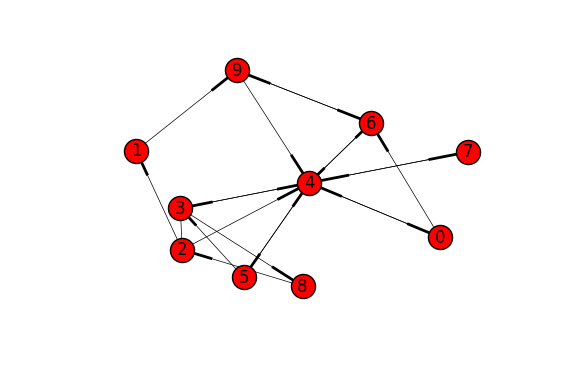

In [14]:
N, p = 10, 0.2
edges = random_graph(N, p)

G = networkx.DiGraph()
G.add_edges_from(edges)
plt.axis('off')
networkx.draw_networkx(G, width=0.5)

Посчитаем его PageRank и изобразим так, чтобы размер вершины был пропорционален ее весу.

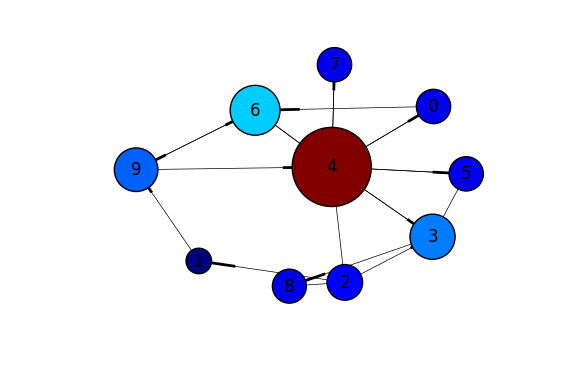

In [37]:
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(edges, start_distribution)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Как мы уже отмечали выше, эргодическая теорема дает верхнюю оценку на скорость сходимости. Давайте посмотрим, насколько она является точной. Для этого при вычислении PageRank нужно установить флаг return_trace.

In [69]:
pr_distribution, pr_trace = page_rank(edges, start_distribution, return_trace=True)

In [70]:
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1))

In [71]:
e = pr_distribution.min()

In [72]:
convergence = []
for i in range(len(errors)):
    convergence += [(1 - e) ** i]

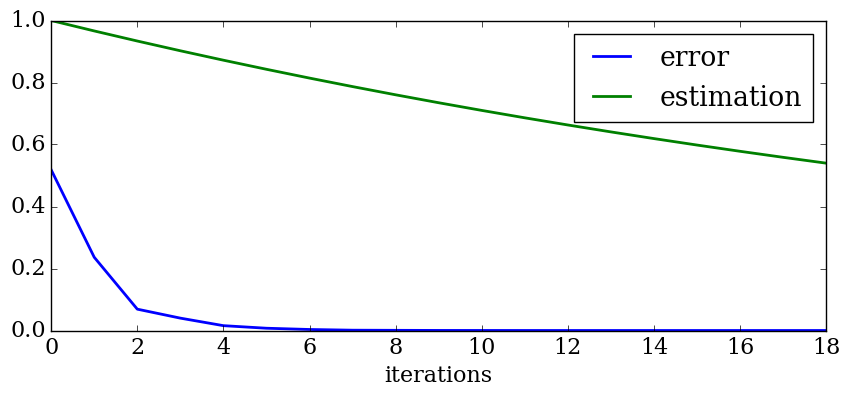

In [83]:
plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, convergence, lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

На практике сходится гораздо быстрее по сравнению с оценкой эргодической теоремы.

Проведите небольшое исследование. В ходе исследования выясните, как скорость сходимости (количество итераций до сходимости) зависит от $n$ и $p$, а так же начального распределения. Вычислите также веса PageRank для некоторых неслучайных графов. В каждом случае стройте графики. От чего зависит вес вершины?

In [162]:
def show_graph_figures(edges, pr_distribution, errors):
    f, ax = subplots(1,3, figsize=(15,3))

    G = networkx.DiGraph()
    G.add_edges_from(edges)
    ax[0].axis('off')
    networkx.draw_networkx(G, width=0.5, ax=ax[0])

    size_const = 10 ** 4
    ax[1].axis('off')
    networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, node_color=pr_distribution, ax=ax[1])

    e = pr_distribution.min()
    convergence = []
    for i in range(len(errors)):
        convergence += [(1 - e) ** i]
    x = np.arange(len(errors))
    ax[2].plot(x, errors, lw=2, label='error')
    ax[2].plot(x, convergence, lw=2, label='estimation')
    ax[2].legend()
    ax[2].set_xlabel('iterations')
    show()

In [167]:
def find_convergence_rate(N, p, damping_factor=0.15, show=False):
    edges = random_graph(N, p)
    start_distribution = np.ones((1, N)) / N
    pr_distribution, pr_trace = page_rank(edges, start_distribution, damping_factor=damping_factor, return_trace=True)
    errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1))
    
    if show:
        print("N = {}, p = {}, damping factor = {}".format(N, int(100 * p) / 100, int(100 * damping_factor) / 100))
        show_graph_figures(edges, pr_distribution, errors)
    
    return len(errors)

N = 30, p = 0.2, damping factor = 0.1


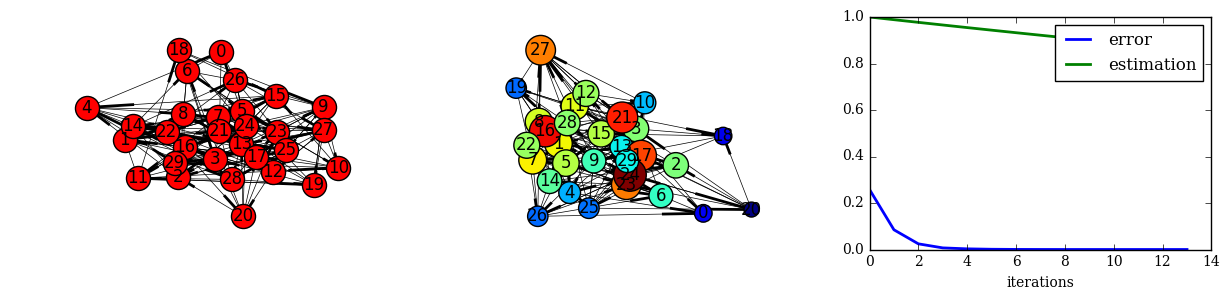

N = 30, p = 0.2, damping factor = 0.3


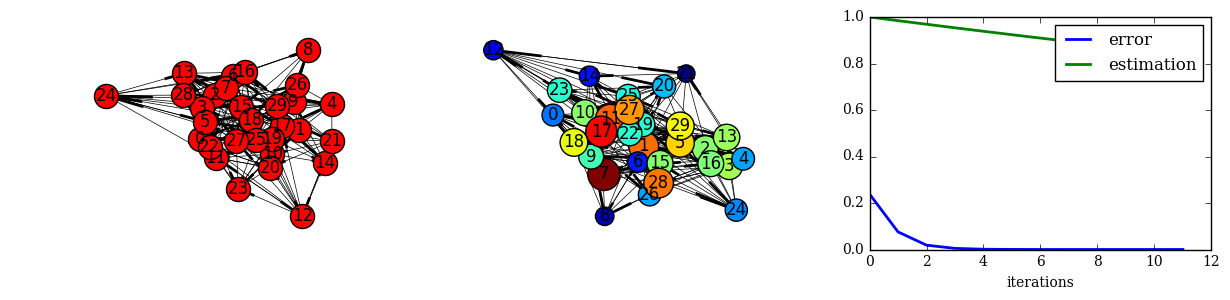

N = 30, p = 0.4, damping factor = 0.1


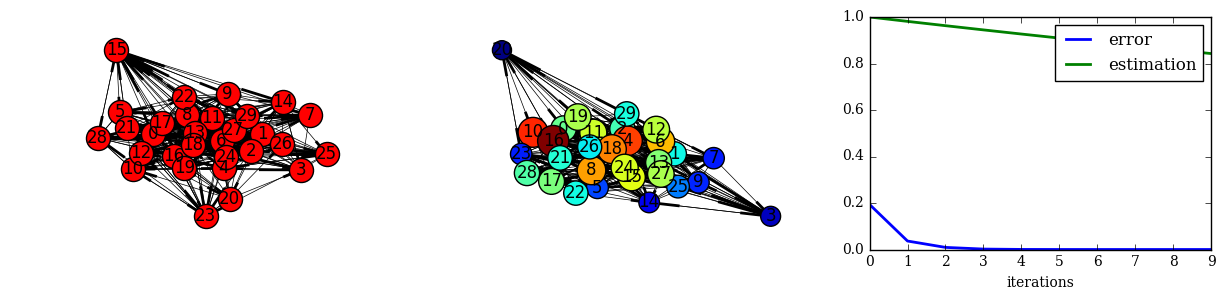

N = 30, p = 0.4, damping factor = 0.3


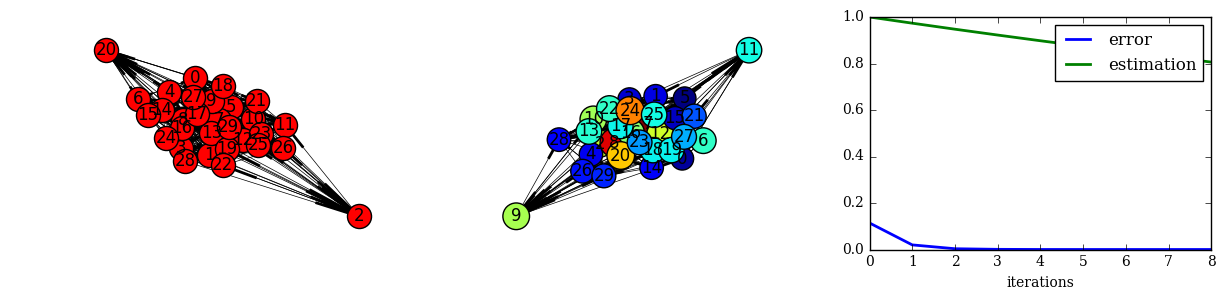

In [169]:
random.seed(123)

N = 30
for p in range(2, 5, 2):
    for damping_factor in range(1, 4, 2):
        find_convergence_rate(N, 0.1 * p, 0.1 * damping_factor, show=True)

In [170]:
random.seed(123)

iteration_numbers = np.zeros((10, 10))
N = 50
for p in range(2, 10, 1):
    for damping_factor in range(1, 10, 1):
        iteration_number = find_convergence_rate(N, 0.1 * p, 0.1 * damping_factor)
        iteration_numbers[p, damping_factor] = iteration_number

In [172]:
%%time
random.seed(123)

iteration_numbers = np.zeros((10, 10))
N = 50
experiments_number = 3
for p in range(2, 10, 1):
    for damping_factor in range(1, 10, 1):
        for experiment_index in range(experiments_number):
            iteration_number = find_convergence_rate(N, 0.1 * p, 0.1 * damping_factor)
            iteration_numbers[p, damping_factor] += iteration_number
        iteration_numbers[p, damping_factor] /= 3

CPU times: user 7min 24s, sys: 4.63 s, total: 7min 29s
Wall time: 7min 42s


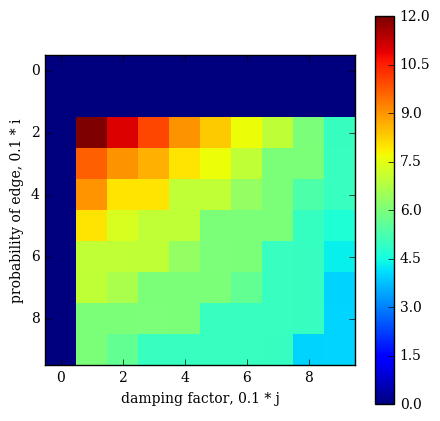

In [173]:
figure(figsize=(5,5))
imshow(iteration_numbers, interpolation='None')
ylabel('probability of edge, 0.1 * i')
xlabel('damping factor, 0.1 * j')
colorbar()

Итак, чем меньше вероятность ребра и выбора случайной страницы вместо перехода по ссылке, тем больше итераций нужно для достижения сходимости.

## Часть 2

В этой части вам предстоит построить реальный веб-граф и посчитать его PageRank. Ниже определены вспомогательные функции.

In [4]:
def load_links(url, sleep_time=1, attempts=5, timeout=20):
    ''' Загружает страницу по ссылке url и выдает список ссылок, 
    на которые ссылается данная страница.
        url --- string, адрес страницы в интернете;
        sleep_time --- задержка перед загрузкой страницы;
        timeout --- время ожидания загрузки страницы;
        attempts --- число попыток загрузки страницы. 
        Попытка считается неудачной, если выбрасывается исключение.
    
        В случае, если за attempts попыток не удалось загрузить страницу,
        то последнее исключение пробрасывается дальше.
    '''
    
    sleep(sleep_time)
    parsed_url = urlparse(url)
    links = []

    # Попытки загрузить страницу
    for i in range(attempts):
        try:
            # Ловить исключения только из urlopen может быть недостаточно. 
            # Он может выдавать какой-то бред вместо исключения, 
            # из-за которого исключение сгенерирует BeautifulSoup
            soup = BeautifulSoup(urlopen(url, timeout=timeout), 'html.parser')
            break
            
        except Exception as e:
            print(e)
            if i == attempts - 1:
                raise e

    for tag_a in soup('a'):  # Посмотр всех ссылочных тегов
        if 'href' in tag_a.attrs:
            link = list(urlparse(tag_a['href']))
            
            # Если ссылка является относительной,
            # то ее нужно перевести в абсолютную
            if link[0] == '': link[0] = parsed_url.scheme
            if link[1] == '': link[1] = parsed_url.netloc
            
            links.append(urlunparse(link))
            
    return links


def get_site(url):
    ''' По ссылке url возвращает адрес сайта. '''
    
    return urlparse(url).netloc

Код ниже загружает $N$ веб-страниц, начиная с некоторой стартовой страницы и переходя по ссылкам. Загрузка происходит методом обхода в ширину. Все собранные урлы страниц хранятся в urls. В links хранится список ссылок с одной страницы на другую. Особенность кода такова, что в urls хранятся все встреченные урлы, которых может быть сильно больше $N$. Аналогично, в links ребра могут ссылаться на страницы с номером больше $N$. Однако, все ребра из links начинаются только в первых $N$ страницах. Таким образом, для построения веб-графа нужно удалить все, что связано с вершинами, которые не входят в первые $N$.

Это очень примерный шаблон, к тому же не оптимальный. Можете вообще его не использовать и написать свое.

In [213]:
urls = ['http://wikipedia.org/wiki/']
site = get_site(urls[0])
links = []

N = 10
for i in range(N):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(links_from_url[j])))
            
            # Новая ссылка
            else:
                links.append((i, len(urls)))
                urls.append(links_from_url[j])
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно

Теперь выберите какой-нибудь сайт с небольшим количеством страниц (не более 1000). Таким сайтом может быть, например, сайт <a href=http://yandexdataschool.ru>Школы анализа данных</a>, сайт магазина, больницы. Однако, советуем не выбирать сайты типа kremlin.ru, мало ли что.

Постройте полный веб-граф для этого сайта и визуализируйте его. При отрисовке выставляйте width не более 0.1, иначе получится ужасно некрасиво.

Посчитайте PageRank для этого веб-графа. Визуализируйте данный веб-граф, сделав размер вершин пропорционально весу PageRank (см. пример в части 1). Постройте гистограмму весов. Что можно сказать про скорость сходимости?

Выделите небольшое количество (15-20) страниц с наибольшим весом и изобразите граф, индуцированный на этом множестве вершин. Что это за страницы? Почему именно они имеют большой вес?

Как меняется вес PageRank для страниц в зависимости от начального приближения в случае, если не доводить итерационный процесс вычисления до сходимости? Какие выводы о поведении пользователя отсюда можно сделать?

Для получения дополнительных баллов проведите аналогичные исследования для больших сайтов. Так же вы можете провести исследования, не ограничиваясь загрузкой только одного сайта.

Рассмотрим сайт http://www.squesito.ru, где продают кофе и кофемашины

In [5]:
%%time

urls = ['http://www.squesito.ru/']
site = get_site(urls[0])
links = []

i = 0
while i < len(urls):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, links_from_url))
        links_from_url = list(filter(lambda x: x.startswith('http'), links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(links_from_url[j])))
            
            # Новая ссылка
            else:
                links.append((i, len(urls)))
                urls.append(links_from_url[j])
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно
    i += 1

HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHA

CPU times: user 21.9 s, sys: 1.8 s, total: 23.7 s
Wall time: 6min 42s


In [229]:
print("Pages number:", len(urls))
print("Links number:", len(links))

Pages number: 446
Links number: 48762


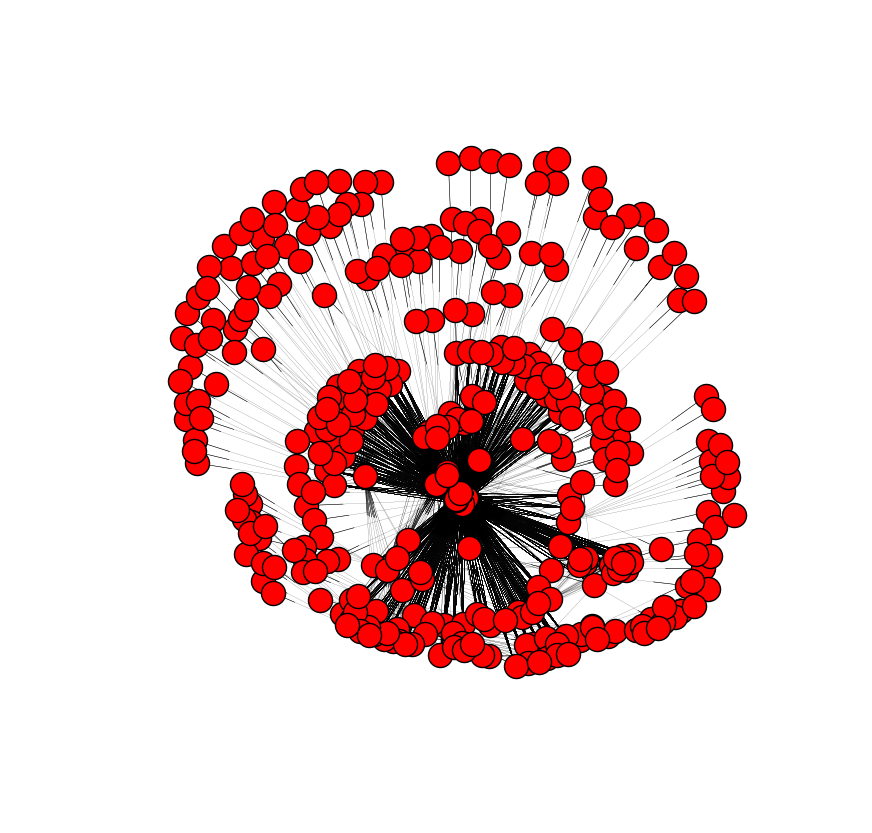

In [238]:
G = networkx.DiGraph()
G.add_edges_from(links)
plt.figure(figsize=(10,10))
plt.axis('off')
networkx.draw_networkx(G, width=0.1, with_labels=False)

In [8]:
N = len(urls)

start_distribution = np.ones((1, N)) / N
pr_distribution, pr_trace = page_rank(links, start_distribution, return_trace=True)

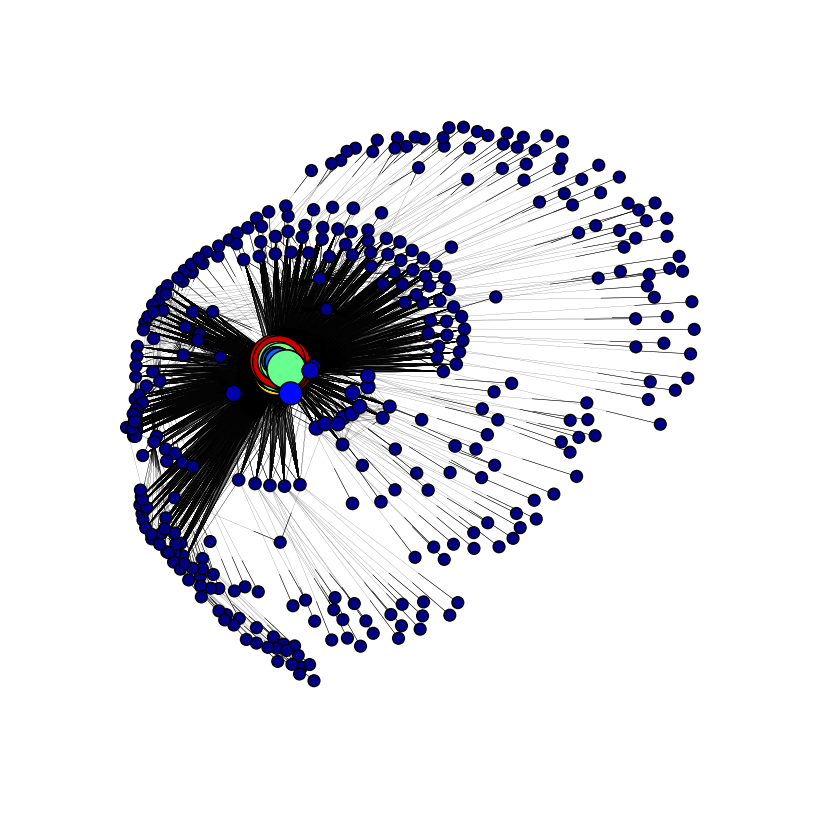

In [10]:
size_const = 10 ** 5
plt.figure(figsize=(10,10))
plt.axis('off')
networkx.draw_networkx(G, width=0.1, node_size=size_const*pr_distribution, node_color=pr_distribution, with_labels=False)

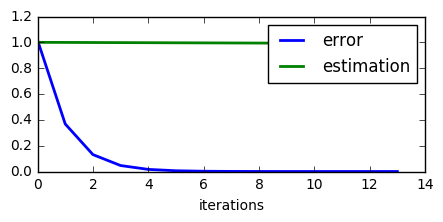

In [11]:
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1))

e = pr_distribution.min()
convergence = []
for i in range(len(errors)):
    convergence += [(1 - e) ** i]
    
plt.figure(figsize=(5, 2))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, convergence, lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

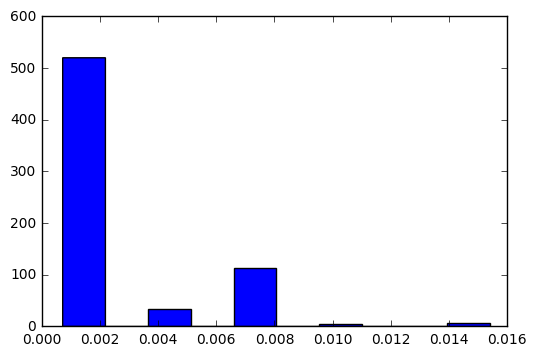

In [14]:
plt.hist(pr_distribution, normed=True)
plt.show()

Рассмотрим 20 страниц с наибольшим весом

In [15]:
urls_indexes = [i for i in range(len(urls))]

In [16]:
urls_indexes_sorted = sorted(urls_indexes, key=lambda i: pr_distribution[i], reverse=True)

In [18]:
nodes_number = 20
weighted_urls_indexes = urls_indexes_sorted[:nodes_number]
weighted_links = list(filter(lambda link: link[0] in weighted_urls_indexes and link[1] in weighted_urls_indexes, links))

In [52]:
weighted_G = G.subgraph(weighted_urls_indexes)
weighted_distribution_nodes = [pr_distribution[i] for i in weighted_G.nodes()]

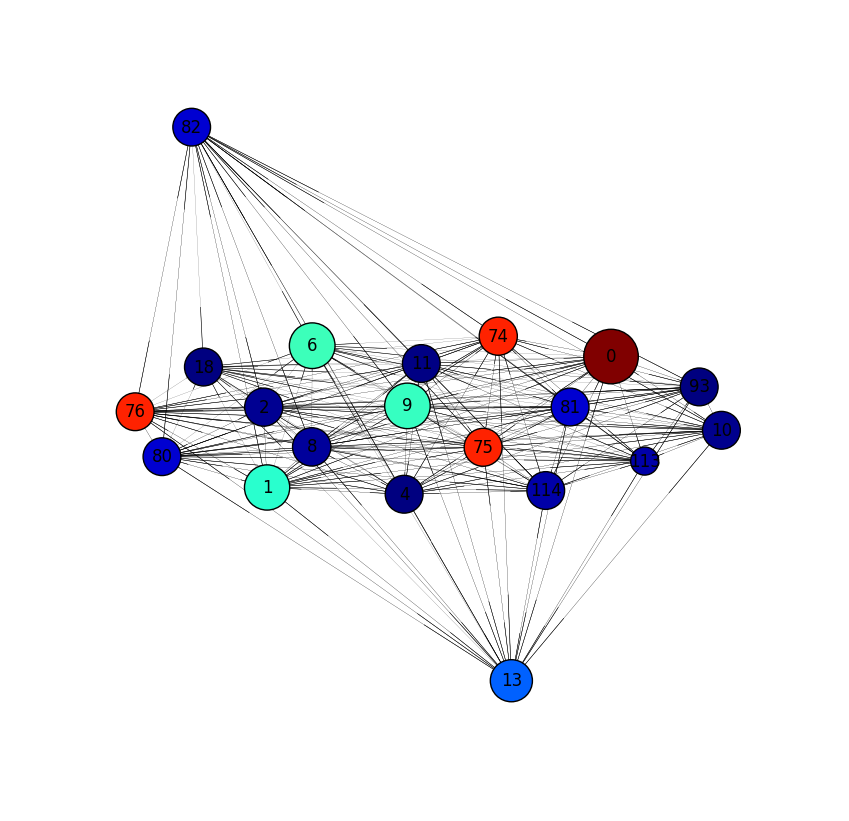

In [41]:
size_const = 10 ** 5
plt.figure(figsize=(10,10))
plt.axis('off')
networkx.draw_networkx(weighted_G, width=0.1, node_size=size_const*pr_distribution, node_color=weighted_distribution_nodes)

In [47]:
weighted_urls = [urls[i] for i in weighted_urls_indexes]
weighted_distribution_sorted = sorted(pr_distribution, reverse=True)[:nodes_number]

In [51]:
weighted_url_info = pd.DataFrame(columns = ['url', 'pagerank'])
weighted_url_info.url = weighted_urls
weighted_url_info.pagerank = weighted_distribution_sorted

weighted_url_info

,url,pagerank
0,http://www.squesito.ru,0.015417
1,http://www.squesito.ru/squesito-arabica.html,0.014416
2,http://www.squesito.ru/squesito-intenso.html,0.014416
3,http://www.squesito.ru/squesito-prezioso.html,0.014416
4,http://www.squesito.ru/optom.html,0.010809
5,http://www.squesito.ru/kofemashiny/,0.010747
6,http://www.squesito.ru/,0.010607
7,http://www.squesito.ru/russia/,0.009182
8,http://www.squesito.ru/squesito-delicato.html,0.007976
9,http://www.squesito.ru/squesito-rainforest.html,0.007976


Наибольший PageRank у главной страницы. Далее идут страницы с наиболее популярными видами кофе. Следом оптовые продажи и продажи кофемашин. Затем еще 3 вида кофе и 2 самые популярные кофемашины. И т д. Выглядит вполне логично. 

Еще можно заметить, что страницы с кофе из одной группы ((arabica, intenso, prezioso), (delicato, rainforest, deka)) имеет абсолютно одинаковый PageRank - скорее всего, на них ведут ссылки с одних и тех же страниц.

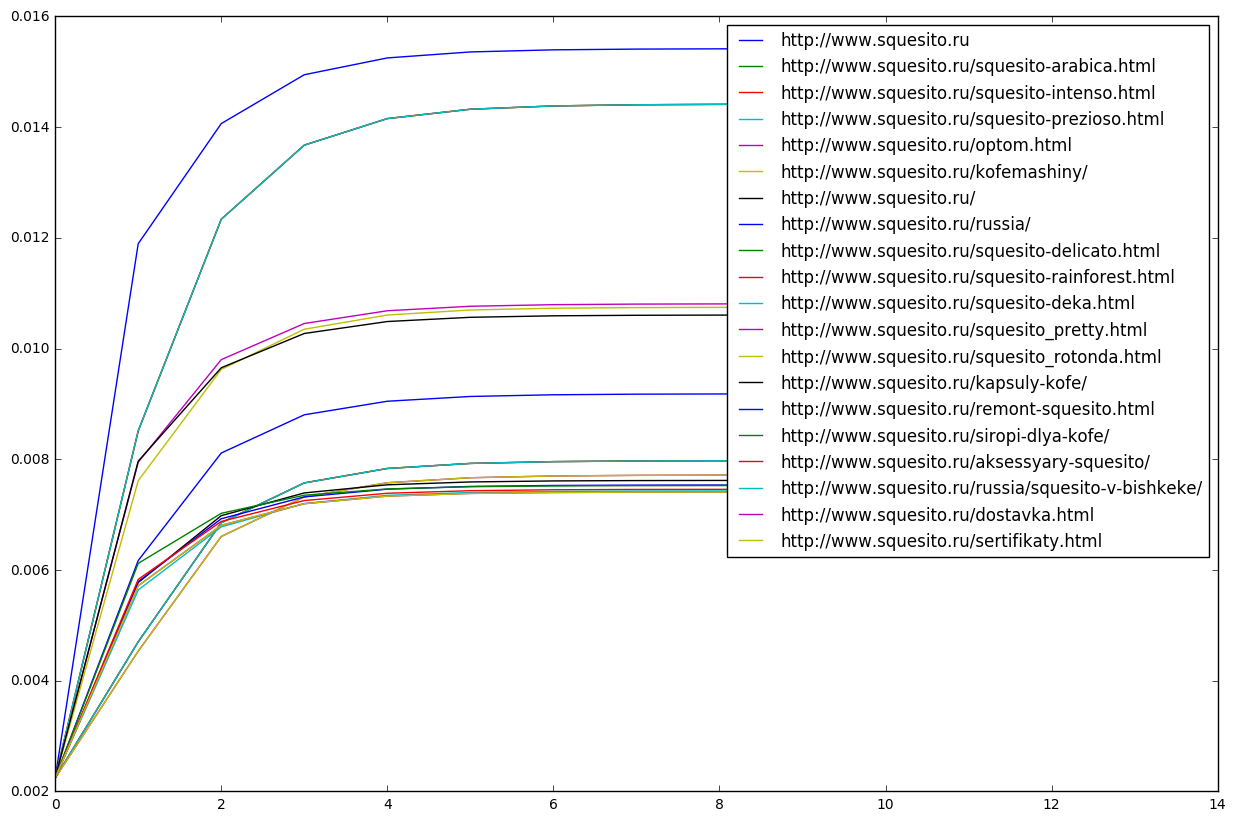

In [76]:
plt.figure(figsize=(15, 10))
for i in weighted_urls_indexes:
    plt.plot(pr_trace[:, i], label=urls[i][:50])
plt.legend()
plt.show()

PageRank страниц движется в сторону сходимости: для более популярных страниц увеличивает, для менее популярных - уменьшается.

## Часть 3

Для выполнения этой части вам потребуется библиотека RankLib https://sourceforge.net/p/lemur/wiki/RankLib/

Скачайте датасет с конкурса «Интернет-математика 2009»
https://academy.yandex.ru/events/data_analysis/grant2009/

Разбейте его на три части train, test, valid размера 10% каждая.
Функции, реализующие это, возьмите с семинара.
Правда, привести файл к формату SVM-Rank (см. документацию по RankLib) придется самостоятельно.

Обучите на train методы MART и LambdaMART на 300 итераций, указав им метрику NDCG и передав так же valid.
Записывайте сюда команды аналогично тому, как это было сделано на семинаре.
Значения метрики в зависимости от номера итерации сохранились в log-файле.
Для считывания поможет приведенная ниже функция.

In [148]:
def read_metric_dependence_from_file(file_name, num_lines, num_blocks=1):
    ''' Извлекает значения метрики в процессе обучения из log-файлов, 
    создаваемых библиотекой RankLib при обучении.
        file_name --- имя log-файла
        num_lines --- число строк, в которых записаны значения. 
                      Смысл --- количество выполненых итераций при обучении.
        num_blocks --- количество блоков значений. 
                       Смысл --- число k в случае k-fold CV
                       
        Возвращает лист из np.array в количестве num_blocks.
    Первый столбец каждого np.array --- номер итерации. Все следующие --- значения.
    '''
    
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4
        block_values = np.array(list(map(lambda x: list(map(float, x.split('|')[:-1])), 
                                         text[index:index + num_lines])))
        if len(block_values) !=0:
            values.append(block_values)

        text = text[index:]
        
    return values

def read_metric_dependence_from_file_randomforest(file_name, num_lines, num_blocks=1):
    ''' Извлекает значения метрики в процессе обучения из log-файлов, 
    создаваемых библиотекой RankLib при обучении.
        file_name --- имя log-файла
        num_lines --- число строк, в которых записаны значения. 
                      Смысл --- количество выполненых итераций при обучении.
        num_blocks --- количество блоков значений. 
                       Смысл --- число k в случае k-fold CV
                       
        Возвращает лист из np.array в количестве num_blocks.
    Первый столбец каждого np.array --- номер итерации. Все следующие --- значения.
    '''
    
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4
        lines = []
        for line in text[index:index + num_lines]:
            line_splitted = line.split('|')[:-1]
            line_splitted[0] = line_splitted[0].split('[')[1].split(']')[0]
            lines += [line_splitted]
        block_values = np.array(list(map(lambda x: list(map(float, x)), lines)))
        values.append(block_values)
        text = text[index:]
        
    return values

In [154]:
def read_given_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            split_line = line.rstrip().split(' ')
            
            # релевантность и id запроса
            relevs.append(split_line[0])
            qids.append(int(split_line[-1]))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[1:-2]:
                index, value = map(float, feat.split(':'))
                object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)

def read_file(file_path, features_count):
    ''' Считывает дата-файл по адресу file_path, в котором есть не более features_count признаков.
    Возвращает список меток релевантности, id запросов и матрицу признаков'''
    
    relevs = []
    qids = []
    features = []
    
    with open(file_path) as data_file:
        for line in data_file:
            split_line = line.split(' ')
            
            # релевантность и id запроса
            relevs.append(split_line[0])
            qids.append(int(split_line[1].split(':')[1]))
            
            # признаки
            object_features = np.zeros(features_count, dtype=float)
            for feat in split_line[2:-1]:
                index, value = map(float, feat.split(':'))
                object_features[index] = value
            
            features.append(object_features)
    
    return relevs, qids, np.array(features)

def write(features, relevs, qids, file_path, index_begin, index_end):
    ''' Создает файл по адресу file_path, в который будут записаны релевантности relevs,
    номера запросов qids и признаки features с номера index_begin по index_end. '''
    
    with open(file_path, 'w') as f:
        for index_line in range(index_begin, index_end):
            f.write('{} qid:{}'.format(relevs[index_line], qids[index_line]))
            for i in range(features.shape[1]):
                f.write(' {}:{}'.format(i + 1, features[index_line, i]))
            f.write('\n')


def split_to_train_valid_test(relevs, qids, features, 
                              train_path, test_path,
                              train_size, test_size,
                              valid_path=None, valid_size=None):
    ''' Разбивает датасет на две или три части, и записывает их в файлы'''

    num_docs = len(qids)
    i_0 = 0
    
    qids = np.array(qids)
    is_new_query = qids[:-1] != qids[1:]  # True в тех позициях, в которых начинается новый запрос
    new_query_positions = np.arange(num_docs - 1)[is_new_query]  # Позиции, в которых начинается новый запрос

    # Ищем позицию, на которой заканчивается train
    allow_positions = new_query_positions > (train_size * num_docs)
    i_1 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    # Ищем позицию, на которой заканчивается test
    allow_positions = new_query_positions > ((train_size + test_size) * num_docs)
    i_2 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

    write(features, relevs, qids, train_path, i_0, i_1)
    write(features, relevs, qids, test_path, i_1, i_2)

    if valid_path is not None:
        # Ищем позицию, на которой заканчивается valid
        allow_positions = new_query_positions > ((train_size + test_size + valid_size) * num_docs)
        i_3 = new_query_positions[allow_positions][0] if np.sum(allow_positions) > 0 else num_docs

        write(features, relevs, qids, valid_path, i_2, i_3)

In [99]:
relevs, qids, features = read_given_file('./data/imat2009_learning.txt', 250)

/Users/rikachka/miniconda3/envs/conda_py3/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [110]:
split_to_train_valid_test(relevs, qids, features,
                          './data/train.txt', './data/test.txt', 0.1, 0.1, 
                          valid_path='./data/valid.txt', valid_size=0.1)

LambdaMART:

In [111]:
! java -jar RankLib-2.1-patched.jar \
    -train ./data/train.txt \
    -test ./data/test.txt \
    -validate ./data/valid.txt \
    -ranker 6 -tree 300 -leaf 5 -metric2t NDCG@10 \
    -save ./model/LambdaMART_300_5.txt \
    > ./model/log_LambdaMART_300_5.txt

MART:

In [112]:
! java -jar RankLib-2.1-patched.jar \
    -train ./data/train.txt \
    -test ./data/test.txt \
    -validate ./data/valid.txt \
    -ranker 0 -tree 300 -leaf 5 -metric2t NDCG@10 \
    -save ./model/MART_300_5.txt \
    > ./model/log_MART_300_5.txt

Постройте график значения метрики NDCG в зависимости от номера итерации на train и valid для ранее обученных моделей MART и LambdaMART.

In [115]:
lambda_mart = read_metric_dependence_from_file('./model/log_LambdaMART_300_5.txt', 300)[0]
mart = read_metric_dependence_from_file('./model/log_MART_300_5.txt', 300)[0]

In [121]:
def get_column(array, index):
    return [line[index] for line in array if line != []]

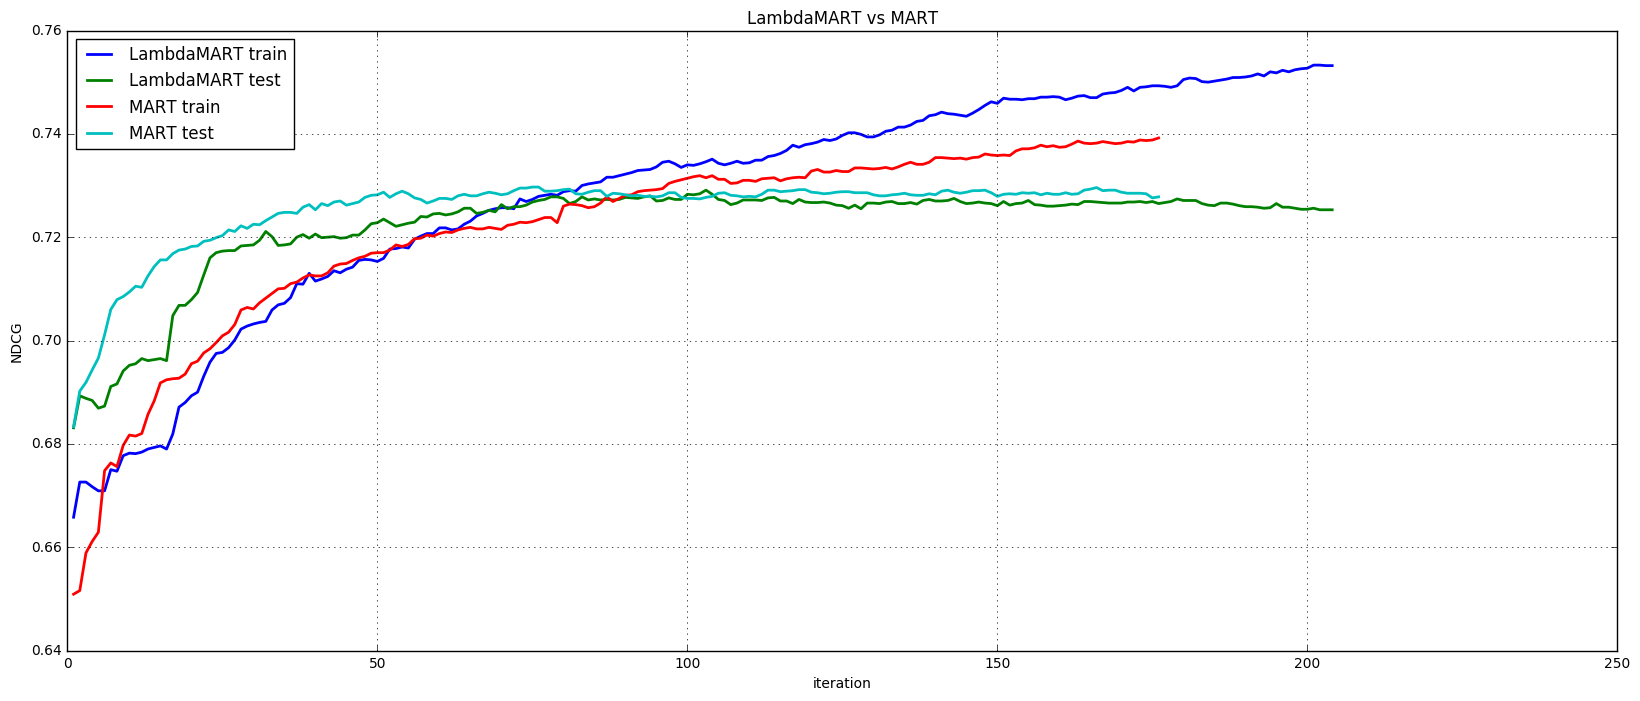

In [122]:
plt.figure(figsize=(20, 8))
plt.plot(get_column(lambda_mart, 0), get_column(lambda_mart, 1), lw=2, label='LambdaMART train')
plt.plot(get_column(lambda_mart, 0), get_column(lambda_mart, 2), lw=2, label='LambdaMART test')
plt.plot(get_column(mart, 0), get_column(mart, 1), lw=2, label='MART train')
plt.plot(get_column(mart, 0), get_column(mart, 2), lw=2, label='MART test')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('LambdaMART vs MART')
plt.legend(loc=2)
plt.grid()
plt.show()

Можно ли сказать, что какая-то модель работает лучше? Достигается ли точка переобучения?

Здесь нельзя сказать, что какая-то из моделей работает лучше. Переобучение произошло, да.

Постройте аналогичные графики для Random Forests и RankNet (по отдельности).
Какие выводы можно сделать?

RandomForest:

In [124]:
! java -jar RankLib-2.1-patched.jar \
    -train ./data/train.txt \
    -test ./data/test.txt \
    -validate ./data/valid.txt \
    -ranker 8 -tree 300 -leaf 5 -metric2t NDCG@10 \
    -save ./model/RandomForest_300_5.txt \
    > ./model/log_RandomForest_300_5.txt

In [145]:
random_forest = read_metric_dependence_from_file_randomforest('./model/log_RandomForest_300_5.txt', 300)[0]

/Users/rikachka/miniconda3/envs/conda_py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


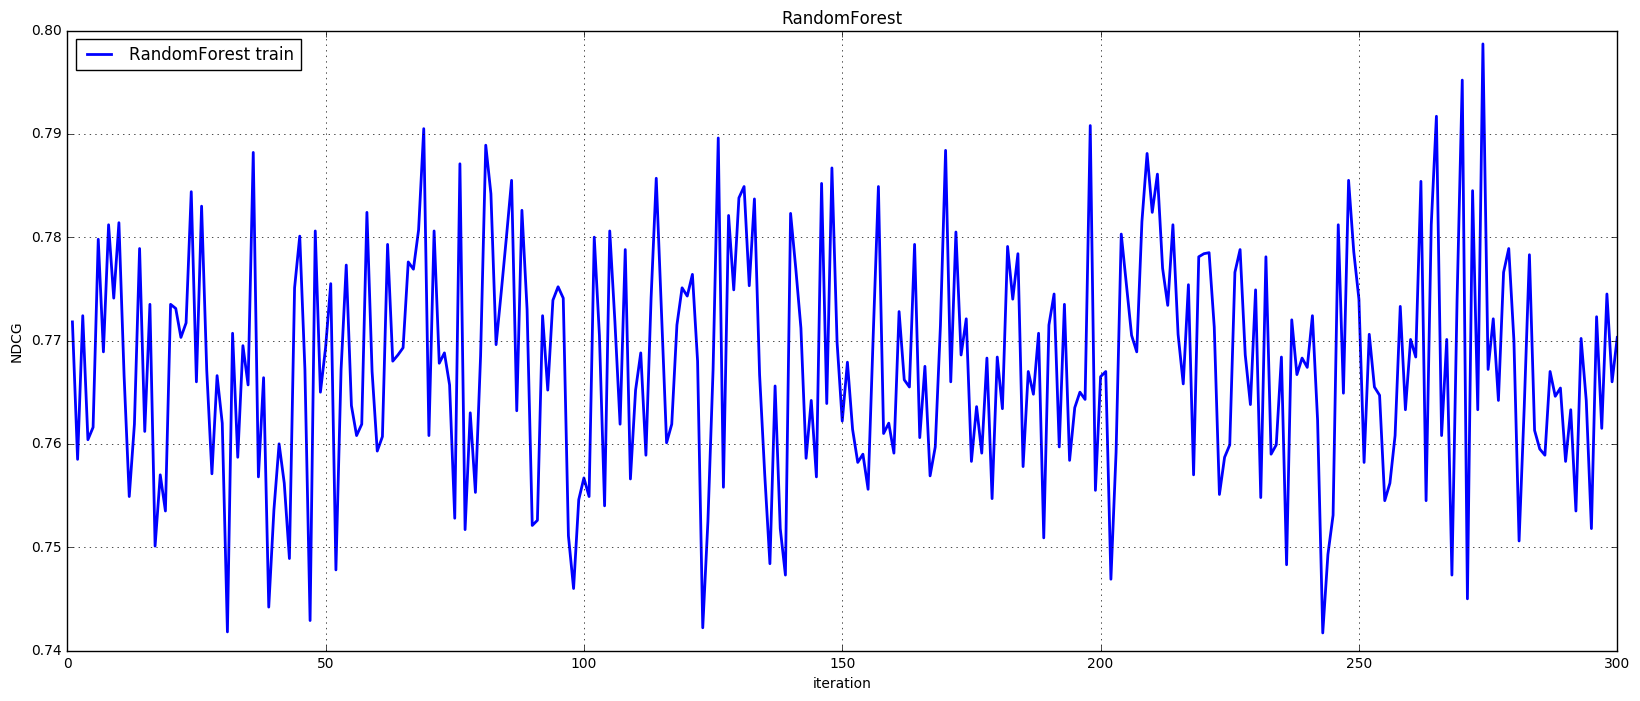

In [147]:
plt.figure(figsize=(20, 8))
plt.plot(get_column(random_forest, 0), get_column(random_forest, 1), lw=2, label='RandomForest train')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('RandomForest')
plt.legend(loc=2)
plt.grid()
plt.show()

RankNet:

In [149]:
! java -jar RankLib-2.1-patched.jar \
    -train ./data/train.txt \
    -test ./data/test.txt \
    -validate ./data/valid.txt \
    -ranker 1 -tree 300 -leaf 5 -metric2t NDCG@10 \
    -save ./model/RankNet_300_5.txt \
    > ./model/log_RankNet_300_5.txt

In [150]:
rank_net = read_metric_dependence_from_file('./model/log_RankNet_300_5.txt', 300)[0]

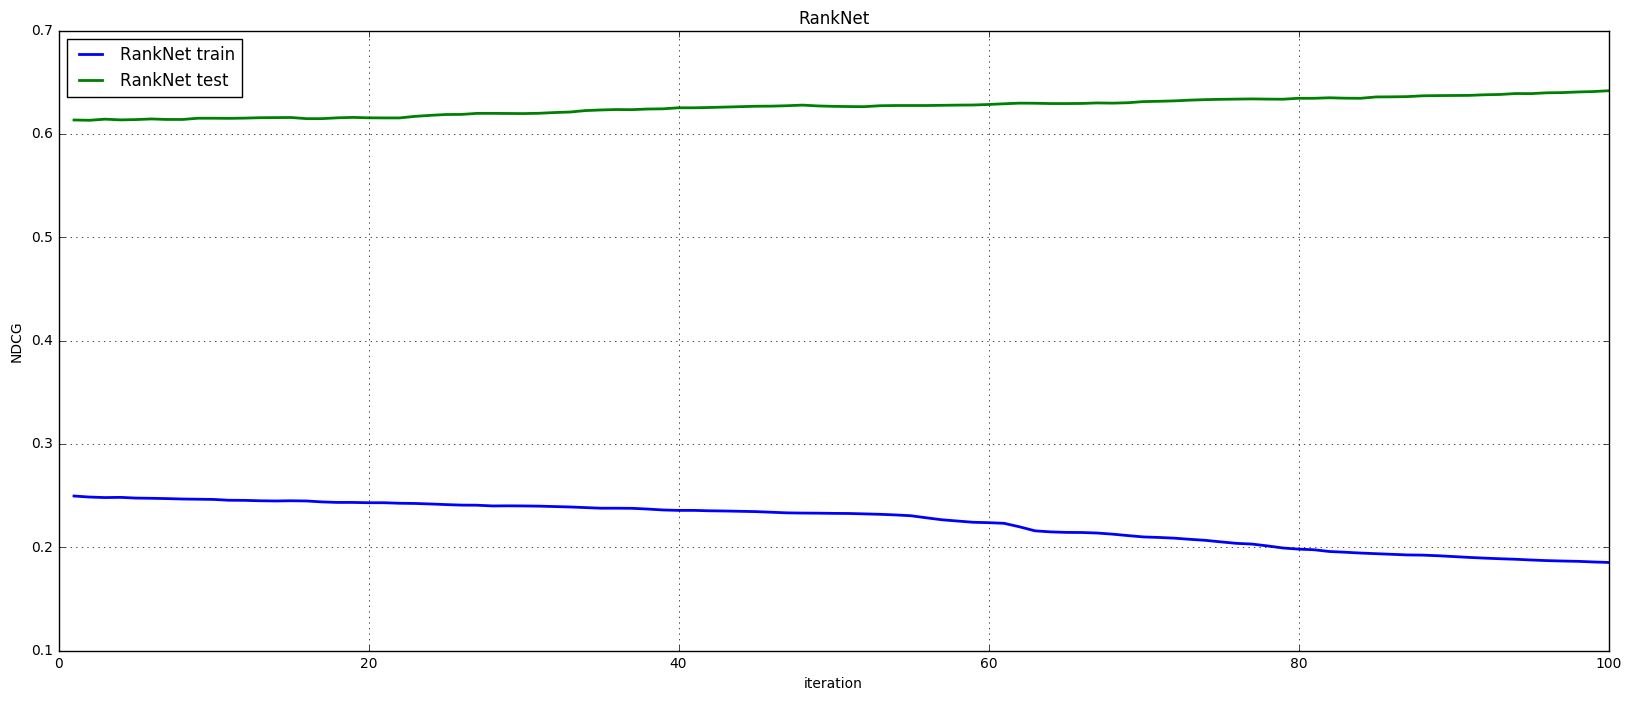

In [151]:
plt.figure(figsize=(20, 8))
plt.plot(get_column(rank_net, 0), get_column(rank_net, 1), lw=2, label='RankNet train')
plt.plot(get_column(rank_net, 0), get_column(rank_net, 2), lw=2, label='RankNet test')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title('RankNet')
plt.legend(loc=2)
plt.grid()
plt.show()

#### Сглаживание дискретных метрик

Одна из основных проблем в обучении ранжированию --- дискретность метрик.
Мы знаем, как решается эта проблема в LambdaRank и LambdaMART (см. вопрос выше).
Однако, в некоторых задачах нужно использовать саму метрику.
В связи с этим возникают задачи разработки сглаженных версий дискретных метрик.
Рассмотрим самый простой из них.

Пусть $X_{train}$ --- обучающая выборка. Разобьем ее на две части независимо $M$ раз: $X_{train} = X_1^m \sqcup X_2^m$, причем разбиение будем производить *по запросам*, то есть пары $(q, d_1)$ и $(q, d_2)$ попадают в одну из этих двух частей. Далее обучаем наш метод на $X_1^m$ и применяем к $X_{test}$ --- тестовая выборка. Так мы получим $M$ чисел $Z_1, ..., Z_M$, каждое из которых есть значение метрики. Их усреднение дает сглаженное значение метрики.

Почему такой способ является нечестным? Как нужно было бы действовать честно?

Честно было бы перебрать все возможные пары разбиений. Потому что так один и тот же запрос может все время оказываться в одной и той же части разбиения.

Теперь вам предстоит построить график сглаженной метрики $NDCG_{10}$ для LambdaMART c 300 деревьями и $M=10$.
Алгоритм примерно следующий:

на каждой итерации
* перемешать $X_{train}$ по запросам. Для этого есть специальная команда, см. описание библиотеки.
* разбить $X_{train}$ на две части. Для этого есть функция с семинара.
* обучить LambdaMART на первой части на 300 деревьях. Валидационную выборку передавать не нужно.
* посчитать значение NDCG на $X_{test}$ по полученной модели в зависимости от количества деревьев.

В последнем пункте имеется ввиду следующее. 
Пусть модель представляется в виде $F(x) = \sum\limits_{t=1}^T \alpha_t f_t(x)$.
Нужно посчитать значение метрики по всем моделям $F(x) = \sum\limits_{t=1}^K \alpha_t f_t(x), K=1, ..., T$.

Для реализации вам потребуется самостоятельно создать файл с такой моделью на основе файла с обученной моделью, который представляет из себя список деревьев с некоторой дополнительной информацией.
Вам нужно в свой файл последовательно добавлять деревья по одному, а затем использовать команду для подсчета значения метрики на тестовой выборке по этой модели, см. описание библиотеки.

Выполнив эти операции, постройте график сглаженной метрики. Сравните с графиком исходной метрики.

In [152]:
def process_model():
    with open('./model/LambdaMART_smoothing.txt') as f:
        model = f.readlines()

    result_test = list()
    for i in range(1, 300):
        tree_index = model.index('\t<tree id="{}" weight="0.1">\n'.format(i+1))
        
        with open('./model/ConstructedModel_smoothing.txt', 'w') as f:
            f.write(''.join(model[:tree_index]))
            f.write(model[-1])
        
        ! java -jar RankLib-2.1-patched.jar \
            -load ./model/ConstructedModel_smoothing.txt \
            -test ./data/test.txt \
            -metric2T NDCG@10 \
            > ./model/log_ConstructedModel_smoothing.txt
        
        with open('./model/log_ConstructedModel_smoothing.txt') as f:
            test = f.readlines()
        
        result_test.append(float(test[-1].split(': ')[1]))
    
    ! java -jar RankLib-2.1-patched.jar \
        -load ./model/LambdaMART_smoothing.txt \
        -test ./data/test.txt \
        -metric2T NDCG@10 \
        > ./model/log_ConstructedModel_smoothing.txt
    
    with open('./model/log_ConstructedModel_smoothing.txt') as f:
        test= f.readlines()
        
    result_test.append(float(test[-1].split(': ')[1]))
    
    return result_test

In [155]:
results_train = list()
results_test = list()

M = 10
for i in range(M):

    ! java -cp RankLib-2.1-patched.jar ciir.umass.edu.features.FeatureManager \
        -input ./data/train.txt -output ./data/ -shuffle 
        
    relevs, qids, features = read_file('./data/train.txt.shuffled', 251)
    
    split_to_train_valid_test(relevs, qids, features, './data/train_part1.txt', './data/train_part2.txt', 0.5, 0.5)

    ! java -jar RankLib-2.1-patched.jar \
        -train ./data/train_part1.txt \
        -test ./data/test.txt \
        -ranker 6 -tree 300 -leaf 5 -metric2t NDCG@10 \
        -save ./model/LambdaMART_smoothing.txt \
        > ./model/log_LambdaMART_smoothing.txt
    
    result_train = read_metric_dependence_from_file('./model/log_LambdaMART_smoothing.txt', 300)[0]
    results_train.append(result_train)

    result_test = process_model()
    results_test.append(result_test)

Reading feature file [./data/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]


/Users/rikachka/miniconda3/envs/conda_py3/lib/python3.5/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Reading feature file [./data/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train.txt]... [Done.]            
(938 ranked lists, 9847 entries read)
Shuffling... [Done]
Saving... [Done]
Reading feature file [./data/train

In [156]:
train_array = np.array([get_column(result, 1) for result in results_train])
train_mean = train_array.mean(axis=0)
train_delta = train_array.std(axis=0)

test_array = np.array(results_test)
test_mean = test_array.mean(axis=0)
test_delta = test_array.std(axis=0)

/Users/rikachka/miniconda3/envs/conda_py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


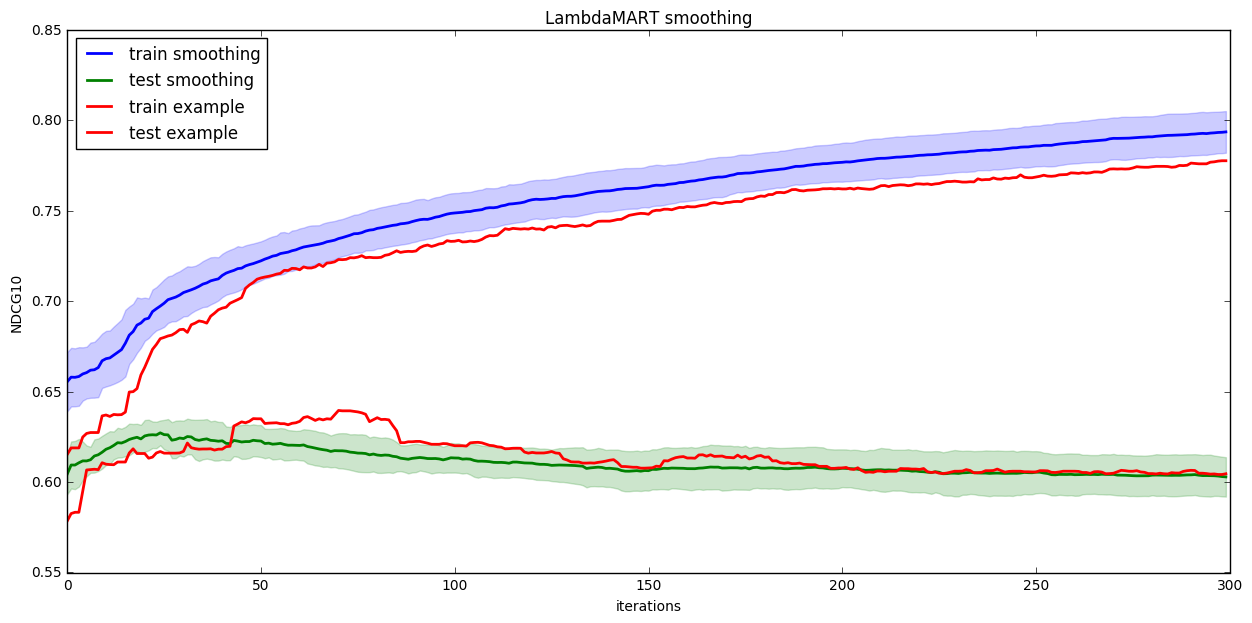

In [160]:
plt.figure(figsize(15,7))
plt.plot(train_mean, label='train smoothing', lw=2, color='blue')
plt.plot(test_mean, label='test smoothing', lw=2, color='green')
plt.plot(train_array[0], label='train example', lw=2, color='red')
plt.plot(test_array[0], label='test example', lw=2, color='red')
plt.fill_between(range(300), train_mean - train_delta, train_mean + train_delta, alpha=0.2, color='blue')
plt.fill_between(range(300), test_mean - test_delta, test_mean + test_delta, alpha=0.2, color='green')
plt.legend(loc=2)
plt.title('LambdaMART smoothing')
plt.ylabel('NDCG10')
plt.xlabel('iterations')
plt.show()